# Final Report
**Author: Víctor Jesús Huárniz Noya** \
**Linkedin: https://www.linkedin.com/in/victor-h-noya/** \
**Data Science: Python - DAT-5301 - MsBA4 - Hult International Business School**

The purpose of this project is to analyze a current data set and run multiple regression and classification models to give insightful feedback and recommendations for the company Apprentice Chef Inc.

### Introduction

After 3 years of operations, we can analyze our data to understand our customers at Apprentice Chef Inc. Our main goals will be to propose specific actions to increase revenue and improve our cross-selling promotions.

## Revenue

Overall, from the KNN model **(R sq= 0.759)**, we can conclude that we might group our customers in groups of 4 to focus our engagement. This can be translated by:
* Giving coupons to refer friends.
* Creating family plans or friends plans.
* Interconnect users and share ads following what they and their closest friends have bought.

Also, we can see from the other models like OLS, that we can also focus on:
* Meals with a rate of 4. Users seem more likely to buy again these orders. We can adjust our app to recommend them again.
* Users that go to any class. We can definitely give some plan pushing classes as well ordering meals. "Go to class with a friend and earn points"

On the next graph we can see that users are most likely to spend a similar amount that their closest 4 neighbors. So, **group them and win**


Model      Train Score      Test Score      Train-Test Gap     Model Size      Model
-----      -----------      ----------      --------------      ----------      -----------                         

OLS        0.656            0.706            0.05            13            [('intercept', 213.93), ('TOTAL_MEALS_ORDERED', 4.37), ('UNIQUE_MEALS_PURCH', -69.11), ('PRODUCT_CATEGORIES_VIEWED', 21.11), ('AVG_TIME_PER_SITE_VISIT', -0.79), ('AVG_PREP_VID_TIME', 9.48), ('AVG_ORDER_SIZE', -112.85), ('MEDIAN_MEAL_RATING', 188.62), ('TOTAL_PHOTOS_VIEWED', 0.48), ('HIGH_CUSTOMER_SERVICE', 153.13), ('EFF_CATEGORIES', 2.92), ('RATING_4', 687.91), ('GO_TO_CLASS', 222.76)]
------------------------------------------------------------------------------------------------------------
Lasso      0.656           0.706            0.049            11            "NR"
------------------------------------------------------------------------------------------------------------
ARD        0.656           0.705 

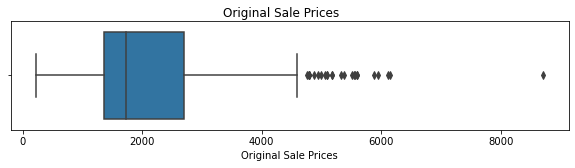

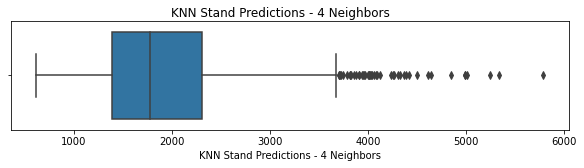

In [2]:
# Regression Models

#########################################################################################################################
#########################################################################################################################
# Data reading and massaging
#########################################################################################################################
#########################################################################################################################
# Correlations
## Importing packages
# importing essential libraries
import pandas as pd  # data science essentials
import matplotlib.pyplot as plt  # essential graphical output
import numpy as np  # essential math
import seaborn as sns  # enhanced graphical output
import statsmodels.formula.api as smf  # regression modeling

#import colors
import colorama
from colorama import Fore, Back, Style

# import packages for massaging
import gender_guesser.detector as gender  # to guess gender of names

# import packages for the models
from sklearn.model_selection import train_test_split  # train/test split
import sklearn.linear_model  # linear Models (scikit-learn) (OLS, Lasso, ARD)
from sklearn.metrics import confusion_matrix  # confusion matrix
from sklearn.metrics import roc_auc_score  # auc score
from sklearn.neighbors import KNeighborsClassifier  # KNN for classification
from sklearn.neighbors import KNeighborsRegressor  # KNN for regression
from sklearn.preprocessing import StandardScaler  # standard scaler
from sklearn.linear_model import LogisticRegression  # logistic regression

# libraries for classification trees
from sklearn.tree import DecisionTreeClassifier  # classification trees
from sklearn.tree import export_graphviz  # exports graphics
from six import StringIO  # saves objects in memory
from IPython.display import Image  # displays on frontend
import pydotplus  # interprets dot objects
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.metrics import make_scorer  # customizable scorer
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.ensemble import GradientBoostingClassifier  # gbm

## Reading datasets
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file names
dataset_file = './data/Apprentice_Chef_Dataset.xlsx'
dictionary_file = './data/Apprentice_Chef_Data_Dictionary.xlsx'

# reading the files into Python
chef = pd.read_excel(dataset_file)
dictionary = pd.read_excel(dictionary_file)

########################################################################################################################
################################################Massaging data##########################################################
########################################################################################################################
########################################################################################################################

## creating a copy of the original data set: "chef_new"

chef_new = chef.copy()

########################################################################################################################
########################################################################################################################

## Renaming variables
# LARGEST_ORDER_SIZE -> AVG_ORDER_SIZE

chef_new.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_ORDER_SIZE'}, inplace=True)

# MOBILE_NUMBER -> HAVE_MOBILE_NUMBER

chef_new.rename(columns={'MOBILE_NUMBER': 'HAVE_MOBILE_NUMBER'}, inplace=True)

########################################################################################################################
########################################################################################################################

## Classifying personal and work emails by domain

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_new.iterrows():

    # splitting email domain at '@'
    split_email = chef_new.loc[index, 'EMAIL'].split(sep="@")

    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)

# converting placeholder_lst into a DataFrame
email_df = pd.DataFrame(placeholder_lst)

# renaming column to concatenate
email_df.columns = ['0', 'email_domain']

# concatenating personal_email_domain with friends DataFrame
chef_new = pd.concat([chef_new, email_df['email_domain']], axis=1)

# email domain types
personal_email_domains = ['@gmail.com', '@yahoo.com', '@protonmail.com']

junk_email_domains = [
    '@msn.com', '@hotmail.com', '@live.com', '@me.com', '@aol.com',
    'passport.com'
]

work_email_domains = [
    '@mmm.com', '@amex.com', '@apple.com', '@boeing.com', '@caterpillar.com',
    '@chevron.com', '@cisco.com', '@cocacola.com', '@disney.com',
    '@dupont.com', '@exxon.com', '@ge.org', '@goldmansacs.com',
    '@homedepot.com', '@ibm.com', '@intel.com', '@jnj.com', '@jpmorgan.com',
    '@mcdonalds.com', '@merck.com', '@microsoft.com', '@nike.com',
    '@pfizer.com', '@pg.com', '@travelers.com', '@unitedtech.com',
    '@unitedhealth.com', '@verizon.com', '@visa.com', '@walmart.com'
]

# placeholder list
placeholder_lst = []

# looping to group observations by domain type
for domain in chef_new['email_domain']:
    if "@" + domain in personal_email_domains:
        placeholder_lst.append('personal')

    elif "@" + domain in junk_email_domains:
        placeholder_lst.append('junk')

    elif "@" + domain in work_email_domains:
        placeholder_lst.append('work')

    else:
        placeholder_lst.append('Nan')

# concatenating with original DataFrame
chef_new['domain_group'] = pd.Series(placeholder_lst)

########################################################################################################################
########################################################################################################################

## New columns to define new variables from other columns

# "EFF_CLICKS_ABV_MEAN" Show if clicks above average give more orders: if above average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] > chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = 0

# "EFF_CLICKS_BELOW_MEAN" Show if clicks above average give more orders: if below or equal average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] <= chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = 0

# "HIGH_CUSTOMER_SERVICE" Efficiency of customer service (if above median, bad):

# looping over CUSTOMER_SERVICE
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] >= chef_new[
            'CONTACTS_W_CUSTOMER_SERVICE'].median():
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 1
    else:
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 0

# "PC_FAN" Efficiency of PC_LOGINS (if above median, fan):

# looping over PC_LOGINS
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'PC_LOGINS'] >= chef_new['PC_LOGINS'].median():
        chef_new.loc[index, 'PC_FAN'] = 1
    else:
        chef_new.loc[index, 'PC_FAN'] = 0

########################################################################################################################
########################################################################################################################

## Creating new variables

# "EFF_PC_PLATFORM" Efficiency of categories : HAVE_MOBILE_NUMBER * PC_LOGINS
""" If user logs in having a phone number, it may mean that PC platform is easier than the app"""

chef_new[
    'EFF_PC_PLATFORM'] = chef_new['HAVE_MOBILE_NUMBER'] * chef_new['PC_LOGINS']

# "EFF_CATEGORIES" Efficiency of categories: TOTAL_MEALS_ORDERED / PRODUCT_CATEGORIES_VIEWED

chef_new['EFF_CATEGORIES'] = chef_new['TOTAL_MEALS_ORDERED'] / chef_new[
    'PRODUCT_CATEGORIES_VIEWED']

# Log Revenue

chef_new['log_REVENUE'] = np.log10(chef_new['REVENUE'])

# Total discounts for cancellations = cancelled before noon + (canceled after noon /2)

chef_new['total_discounts'] = chef_new['CANCELLATIONS_BEFORE_NOON'] + (
    chef_new['CANCELLATIONS_AFTER_NOON'] / 2)

########################################################################################################################
########################################################################################################################

## Get dummies variables for categorical variables

# one hot encoding categorical variables
one_hot_rating = pd.get_dummies(chef_new['MEDIAN_MEAL_RATING'])
one_hot_classes = pd.get_dummies(chef_new['MASTER_CLASSES_ATTENDED'])
one_hot_domain_group = pd.get_dummies(chef_new['domain_group'])

# labels

one_hot_rating.columns = [
    'RATING_1', 'RATING_2', 'RATING_3', 'RATING_4', 'RATING_5'
]
one_hot_classes.columns = ['CLASSES_0', 'CLASSES_1', 'CLASSES_2', 'CLASSES_3']
one_hot_domain_group.columns = [
    'NEW_EMAIL_DOMAIN', 'JUNK_EMAIL', 'PERSONAL_EMAIL', 'WORK_EMAIL'
]

# dropping categorical variables after they've been encoded
chef_new = chef_new.drop('MASTER_CLASSES_ATTENDED', axis=1)
chef_new = chef_new.drop('domain_group', axis=1)
chef_new = chef_new.drop('email_domain', axis=1)

# joining codings together
chef_new = chef_new.join(
    [one_hot_rating, one_hot_classes, one_hot_domain_group])
"""
    ,one_hot_email_domain
"""

# saving new columns
new_columns = chef_new.columns

########################################################################################################################
########################################################################################################################

# New variables from dummies

# "GOOD_ORDERS". Number of orders with 4 or 5 stars:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'RATING_4'] + chef_new.loc[index, 'RATING_5'] >= 1:
        chef_new.loc[index, 'GOOD_ORDERS'] = 1
    else:
        chef_new.loc[index, 'GOOD_ORDERS'] = 0

# "GO_TO_CLASS". Number of people that attend at least one class:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CLASSES_1'] + chef_new.loc[
            index, 'CLASSES_2'] + chef_new.loc[index, 'CLASSES_3'] >= 1:
        chef_new.loc[index, 'GO_TO_CLASS'] = 1
    else:
        chef_new.loc[index, 'GO_TO_CLASS'] = 0

########################################################################################################################
###################################Creating train/test for regression model#############################################
########################################################################################################################
# Dropping insignificant variables for regression model

chef_regression = chef_new.drop([
    'NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME', 'PC_FAN',
    'EFF_CLICKS_ABV_MEAN', 'EFF_PC_PLATFORM', 'PC_LOGINS', 'total_discounts',
    'AVG_CLICKS_PER_VISIT', 'REFRIGERATED_LOCKER', 'EARLY_DELIVERIES',
    'JUNK_EMAIL', 'RATING_2', 'CLASSES_0', 'CLASSES_1', 'CLASSES_2',
    'CLASSES_3', 'RATING_3', 'GOOD_ORDERS', 'CANCELLATIONS_AFTER_NOON',
    'LATE_DELIVERIES', 'TASTES_AND_PREFERENCES', 'WEEKLY_PLAN',
    'CANCELLATIONS_BEFORE_NOON', 'HAVE_MOBILE_NUMBER', 'RATING_1',
    'PACKAGE_LOCKER', 'MOBILE_LOGINS', 'WORK_EMAIL', 'PERSONAL_EMAIL',
    'EFF_CLICKS_BELOW_MEAN', 'CONTACTS_W_CUSTOMER_SERVICE', 'NEW_EMAIL_DOMAIN',
    'RATING_5', 'CROSS_SELL_SUCCESS'
],
                                axis=1)
########################################################################################################################
########################################################################################################################

# creating a (Pearson) correlation matrix
chef_corr = chef_regression.corr().round(2)

#printing (Pearson) correlations with SalePrice
#print(chef_corr.loc['REVENUE'].sort_values(ascending=False) )  # Revenue for regression and Cross sell for classification

########################################################################################################################
########################################################################################################################
# Settting y and x

# Setting y
chef_target_reg = chef_regression.loc[:, 'REVENUE']

# Setting explanatory variables (x)
chef_data_reg = chef_regression.drop(['REVENUE', 'log_REVENUE'], axis=1)

x_variables_reg = list(chef_data_reg.columns)

# Setting up train-test split
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
    chef_data_reg,  # x-variables
    chef_target_reg,  # y-variable
    test_size=0.25,
    random_state=219)

########################################################################################################################
########################################################################################################################

## Standarized data

# INSTANTIATING a StandardScaler() object
scaler_reg = StandardScaler()

# FITTING the scaler with chef_data
scaler_reg.fit(chef_data_reg)

# TRANSFORMING our data after fit
x_scaled_reg = scaler_reg.transform(chef_data_reg)

# converting scaled data into a DataFrame
x_scaled_df_reg = pd.DataFrame(x_scaled_reg)

# adding labels to the scaled DataFrame
x_scaled_df_reg.columns = chef_data_reg.columns

# Setting up STANDARD train-test split

x_train_reg_STAND, x_test_reg_STAND, y_train_reg_STAND, y_test_reg_STAND = train_test_split(
    x_scaled_df_reg, chef_target_reg, test_size=0.25, random_state=219)

########################################################################################################################
###################################USER DEFINED FUNCTIONS###############################################################
########################################################################################################################


# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize=True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""

    if standardize == True:
        # optionally standardizing X_data
        scaler = StandardScaler()
        scaler.fit(x_data)
        x_scaled = scaler.transform(x_data)
        x_scaled_df = pd.DataFrame(x_scaled)
        x_data = x_scaled_df

    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size=pct_test,
                                                        random_state=seed)

    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []

    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)

    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors=n_neighbors)
            clf.fit(x_train, y_train)

        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(x_train, y_train)

        else:
            print("Error: response_type must be 'reg' or 'class'")

        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))

        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))

    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12, 8))
        plt.plot(neighbors_settings,
                 training_accuracy,
                 label="training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()

    # returning optimal number of neighbors
    print(
        f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}"
    )
    return test_accuracy.index(max(test_accuracy)) + 1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels=None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true=true_y, y_pred=pred_y)

    # heatmap
    sns.heatmap(cm,
                annot=True,
                xticklabels=lbls,
                yticklabels=lbls,
                cmap='Blues',
                fmt='g')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()


########################################
# display_tree
########################################
def display_tree(tree, feature_df, height=500, width=800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    # exporting tree to graphviz
    export_graphviz(decision_tree=tree,
                    out_file=dot_data,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_df.columns)

    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # creating image
    img = Image(graph.create_png(), height=height, width=width)

    return img


########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export=False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """

    # declaring the number
    n_features = x_train.shape[1]

    # setting plot window
    fig, ax = plt.subplots(figsize=(12, 9))

    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')


########################################
# defining a function for boxplots
########################################


def model_boxplots(model, data):
    """
	This function is designed to generate a boxplot for predictions to compare.
    
    PARAMETERS
	----------
	model    : Model Predictions
	data     : DataFrame of the response and categorical variables
	"""

    fig, ax = plt.subplots(figsize=(10, 2))

    sns.boxplot(x=model, data=data)

    plt.suptitle(model)
    plt.show()
'''
# merging X_train and y_train so that they can be used in statsmodels
chef__reg_train = pd.concat([x_train_reg, y_train_reg], axis=1)

# Step 1: build a model
lm_best = smf.ols(formula="""REVENUE ~  TOTAL_MEALS_ORDERED +
                                        UNIQUE_MEALS_PURCH +
                                        AVG_TIME_PER_SITE_VISIT +
                                        PRODUCT_CATEGORIES_VIEWED+
                                        EFF_CATEGORIES+
                                        AVG_PREP_VID_TIME +
                                        AVG_ORDER_SIZE +
                                        MEDIAN_MEAL_RATING +
                                        TOTAL_PHOTOS_VIEWED +
                                        HIGH_CUSTOMER_SERVICE +
                                        RATING_4 +
                                        GO_TO_CLASS   """,
                  data=chef__reg_train)

# Step 2: fit the model based on the data
results = lm_best.fit()

# Step 3: analyze the summary output
print(results.summary())
'''
#########################################################################################################################
#########################################################################################################################
#MODELS
#########################################################################################################################
#########################################################################################################################

# INSTANTIATING a model object
lr = sklearn.linear_model.LinearRegression()

# FITTING to the training data
lr_fit = lr.fit(x_train_reg, y_train_reg)

# PREDICTING on new data
lr_pred = lr_fit.predict(x_test_reg)
'''
# SCORING the results
print('OLS Training Score :',
      lr.score(x_train_reg, y_train_reg).round(4))  # using R-square
print('OLS Testing Score  :',
      lr.score(x_test_reg, y_test_reg).round(4))  # using R-square
print('OLS Train-Test Gap :', abs(lr_train_score - lr_test_score).round(4))
'''
lr_train_score = lr.score(x_train_reg, y_train_reg).round(4)
lr_test_score = lr.score(x_test_reg, y_test_reg).round(4)

# saving the gap between training and testing
lr_test_gap = abs(lr_train_score - lr_test_score).round(4)

# zipping each feature name to its coefficient
lr_model_values = zip(chef_data_reg[x_variables_reg].columns,
                      lr_fit.coef_.round(decimals=2))

# setting up a placeholder list to store model features
lr_model_lst = [('intercept', lr_fit.intercept_.round(decimals=2))]

# dropping coefficients that are equal to zero

for feature, coefficient in lr_model_lst:
    if int(coefficient) == 0:
        lr_model_lst.remove((feature, coefficient))

# printing out each feature-coefficient pair one by one
for val in lr_model_values:
    lr_model_lst.append(val)

# INSTANTIATING a model object
lasso_model = sklearn.linear_model.Lasso(alpha=0.01, normalize=True)

# FITTING to the training data
lasso_model_fit = lasso_model.fit(x_train_reg, y_train_reg)

# PREDICTING on new data
lasso_model_pred = lasso_model_fit.predict(x_test_reg)
"""
# SCORING the results
print('Lasso Model Training Score :',
      lasso_model.score(x_train_reg, y_train_reg).round(4))  # using R-square
print('Lasso Model Testing Score  :',
      lasso_model.score(x_test_reg, y_test_reg).round(4))  # using R-square
print('Lasso Model Train-Test Gap :',
      abs(lasso_model_train_score - lasso_model_test_score).round(4))
"""
lasso_model_train_score = lasso_model.score(x_train_reg, y_train_reg).round(4)
lasso_model_test_score = lasso_model.score(x_test_reg, y_test_reg).round(4)

# saving the gap between training and testing
lasso_model_test_gap = abs(lasso_model_train_score -
                           lasso_model_test_score).round(4)

# zipping each feature name to its coefficient
lasso_model_values = zip(chef_data_reg[x_variables_reg].columns,
                         lasso_model_fit.coef_.round(decimals=2))

# setting up a placeholder list to store model features
lasso_model_lst = [('intercept', lasso_model_fit.intercept_.round(decimals=2))]

# printing out each feature-coefficient pair one by one
for val in lasso_model_values:
    lasso_model_lst.append(val)

# dropping coefficients that are equal to zero
for feature, coefficient in lasso_model_lst:
    if int(coefficient) == 0:
        lasso_model_lst.remove((feature, coefficient))
# INSTANTIATING a model object
ard_model = sklearn.linear_model.ARDRegression()

# FITTING the training data
ard_fit = ard_model.fit(x_train_reg, y_train_reg)

# PREDICTING on new data
ard_pred = ard_fit.predict(x_test_reg)
"""
print('ARD Training Score:',
      ard_model.score(x_train_reg, y_train_reg).round(4))
print('ARD Testing Score :', ard_model.score(x_test_reg, y_test_reg).round(4))
print('ARD Train-Test Gap :', abs(ard_train_score - ard_test_score).round(4))
"""
# saving scoring data for future use
ard_train_score = ard_model.score(x_train_reg, y_train_reg).round(4)
ard_test_score = ard_model.score(x_test_reg, y_test_reg).round(4)

# saving the gap between training and testing
ard_test_gap = abs(ard_train_score - ard_test_score).round(4)

# zipping each feature name to its coefficient
ard_model_values = zip(chef_data_reg.columns, ard_fit.coef_.round(decimals=2))

# setting up a placeholder list to store model features
ard_model_lst = [('intercept', ard_fit.intercept_.round(decimals=2))]

# printing out each feature-coefficient pair one by one
for val in ard_model_values:
    ard_model_lst.append(val)

# dropping coefficients that are equal to zero
for feature, coefficient in ard_model_lst:
    if int(coefficient) == 0:
        ard_model_lst.remove((feature, coefficient))
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy = []
gap = []

# building a visualization of 1 to 15 neighbors
neighbors_settings = range(1, 15)

for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors=n_neighbors, p=1)
    clf.fit(x_train_reg, y_train_reg)

    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train_reg, y_train_reg))

    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test_reg, y_test_reg))

    # Recording the gap
    gap.append(
        clf.score(x_train_reg, y_train_reg) -
        clf.score(x_test_reg, y_test_reg))
"""
# plotting the visualization
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()
"""
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
while gap[opt_neighbors - 1] >= 0.05:
    opt_neighbors = test_accuracy.index(max(test_accuracy[opt_neighbors:])) + 1
#"""
# print(f"""The optimal number of neighbors is {opt_neighbors}""")
#"""
###############################################################
# INSTANTIATING a model with the optimal number of neighbors
knn_opt = KNeighborsRegressor(algorithm='auto', n_neighbors=opt_neighbors, p=1)

# FITTING the model based on the training data
knn_opt_fit = knn_opt.fit(x_train_reg, y_train_reg)

# PREDITCING on new data
knn_opt_pred = knn_opt_fit.predict(x_test_reg)
"""
# SCORING the results
print('KNN Training Score:', knn_opt.score(x_train_reg, y_train_reg).round(4))
print('KNN Testing Score :', knn_opt.score(x_test_reg, y_test_reg).round(4))
print('KNN Train-Test Gap:',
      abs(knn_opt_score_train - knn_opt_score_test).round(4))

"""
# saving scoring data for future use
knn_opt_score_train = knn_opt.score(x_train_reg, y_train_reg).round(4)
knn_opt_score_test = knn_opt.score(x_test_reg, y_test_reg).round(4)

# saving the gap between training and testing
knn_opt_test_gap = abs(knn_opt_score_train - knn_opt_score_test).round(4)

# creating lists for training set accuracy and test set accuracy
training_accuracy_STAND = []
test_accuracy_STAND = []
gap_STAND = []

# building a visualization of 1 to 15 neighbors
neighbors_settings_STAND = range(1, 15)

for n_neighbors in neighbors_settings_STAND:
    # Building the model
    clf_STAND = KNeighborsRegressor(n_neighbors=n_neighbors, p=1)
    clf_STAND.fit(x_train_reg_STAND, y_train_reg_STAND)

    # Recording the training set accuracy
    training_accuracy_STAND.append(
        clf_STAND.score(x_train_reg_STAND, y_train_reg_STAND))

    # Recording the generalization accuracy
    test_accuracy_STAND.append(
        clf_STAND.score(x_test_reg_STAND, y_test_reg_STAND))

    # Recording the gap
    gap_STAND.append(
        clf_STAND.score(x_train_reg_STAND, y_train_reg_STAND) -
        clf_STAND.score(x_test_reg_STAND, y_test_reg_STAND))
"""
# plotting the visualization
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(neighbors_settings_STAND,
         training_accuracy_STAND,
         label="training accuracy STAND")
plt.plot(neighbors_settings_STAND,
         test_accuracy_STAND,
         label="test accuracy STAND")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()
"""
opt_neighbors_STAND = test_accuracy_STAND.index(max(test_accuracy_STAND)) + 1
while gap_STAND[opt_neighbors_STAND - 1] >= 0.05:
    opt_neighbors_STAND = test_accuracy_STAND.index(
        max(test_accuracy_STAND[opt_neighbors_STAND:])) + 1
#"""
#print(f"""The optimal number of neighbors is {opt_neighbors_STAND}""")
#"""
###############################################################
# INSTANTIATING a model with the optimal number of neighbors
knn_opt_STAND = KNeighborsRegressor(algorithm='auto',
                                    p=1,
                                    n_neighbors=opt_neighbors_STAND)

# FITTING the model based on the training data
knn_opt_fit_STAND = knn_opt_STAND.fit(x_train_reg_STAND, y_train_reg_STAND)

# PREDITCING on new data
knn_opt_pred_STAND = knn_opt_fit_STAND.predict(x_test_reg_STAND)
"""
# SCORING the results
print('KNN Training Score STAND:',
      knn_opt_STAND.score(x_train_reg_STAND, y_train_reg_STAND).round(4))
print('KNN Testing Score STAND:',
      knn_opt_STAND.score(x_test_reg_STAND, y_test_reg_STAND).round(4))
# displaying and saving the gap between training and testing
print('KNN Train-Test Gap STAND:',
      abs(knn_opt_score_train_STAND - knn_opt_score_test_STAND).round(4))

"""
# saving scoring data for future use
knn_opt_score_train_STAND = knn_opt_STAND.score(x_train_reg_STAND,
                                                y_train_reg_STAND).round(4)
knn_opt_score_test_STAND = knn_opt_STAND.score(x_test_reg_STAND,
                                               y_test_reg_STAND).round(4)
knn_opt_test_gap_STAND = abs(knn_opt_score_train_STAND -
                             knn_opt_score_test_STAND).round(4)

# comparing results

print(f"""
Model      Train Score      Test Score      Train-Test Gap     Model Size      Model
-----      -----------      ----------      --------------      ----------      -----------                         
"""+ Fore.RED+f"""
OLS        {lr_train_score.round(3)}            {lr_test_score.round(3)}            {lr_test_gap.round(3)}            {len(lr_model_lst)}            {lr_model_lst}"""+ Fore.BLACK+f"""
------------------------------------------------------------------------------------------------------------
Lasso      {lasso_model_train_score.round(3)}           {lasso_model_test_score.round(3)}            {lasso_model_test_gap.round(3)}            {len(lasso_model_lst)}            "NR"
------------------------------------------------------------------------------------------------------------
ARD        {ard_train_score.round(3)}           {ard_test_score.round(3)}            {ard_test_gap.round(3)}            {len(ard_model_lst)}            "NR"
------------------------------------------------------------------------------------------------------------
KNN        {knn_opt_score_train.round(3)}           {knn_opt_score_test.round(3)}            {knn_opt_test_gap.round(3)}            {opt_neighbors}            "NA"
------------------------------------------------------------------------------------------------------------"""+ Fore.RED+f"""
KNN_STAND  {knn_opt_score_train_STAND.round(3)}           {knn_opt_score_test_STAND.round(3)}            {knn_opt_test_gap_STAND.round(3)}            {opt_neighbors_STAND}            "NA"
""")

# creating a dictionary for model results
model_performance = {
    'Model Type': ['OLS', 'Lasso', 'ARD', 'KNN', 'KNN_STAND'],
    'Training': [
        lr_train_score, lasso_model_train_score, ard_train_score,
        knn_opt_score_train, knn_opt_score_train_STAND
    ],
    'Testing': [
        lr_test_score, lasso_model_test_score, ard_test_score,
        knn_opt_score_test, knn_opt_score_test_STAND
    ],
    'Train-Test Gap': [
        lr_test_gap, lasso_model_test_gap, ard_test_gap, knn_opt_test_gap,
        knn_opt_test_gap_STAND
    ],
    'Model Size': [
        len(lr_model_lst),
        len(lasso_model_lst),
        len(ard_model_lst), opt_neighbors, opt_neighbors_STAND
    ],
    'Model': [lr_model_lst, lasso_model_lst, ard_model_lst, "NA", "NA"]
}

# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)

# creating dataframe with all predicted values
predictions = pd.DataFrame(
    data={
        'Original Sale Prices': y_test_reg,
        'LR Predictions': lr_pred.round(decimals=2),
        'Lasso Predictions': lasso_model_pred.round(decimals=2),
        'ARD Predictions': ard_pred.round(decimals=2),
        'KNN Predictions': knn_opt_pred.round(decimals=2),
        'KNN Stand Predictions - 4 Neighbors': knn_opt_pred_STAND.round(decimals=2),
        'LR Deviation': lr_pred.round(decimals=2) - y_test_reg,
        'Lasso Deviation': lasso_model_pred.round(decimals=2) - y_test_reg,
        'ARD Deviation': ard_pred.round(decimals=2) - y_test_reg,
        'KNN Deviation': knn_opt_pred.round(decimals=2) - y_test_reg,
        'KNN Stand Deviation': knn_opt_pred_STAND.round(decimals=2) -
        y_test_reg
    })

# sending model results to Excel
model_performance.to_excel('linear_model_performance.xlsx', index=False)

# sending predictions to Excel

predictions.to_excel('predictions.xlsx', index=False)

model_boxplots('Original Sale Prices', predictions)
model_boxplots('KNN Stand Predictions - 4 Neighbors', predictions)

## Cross-sell promotion

For the cross-sell promotion we can recommend with our Forest Tuned Model **(AUC = 0.7212)**:
* Set targeted emails by domain. "Redeem coupon within a week"
* Give extra "forgiveness" coupon to late deliveries.
* Use popular photos in external campaigns.

We can see in the graph the importance of the significant features for Cross-sell promotion.

Forest Tuned Training ACCURACY: 0.8143
Forest Tuned Testing  ACCURACY: 0.8214
Forest Tuned AUC Score        : 0.7212


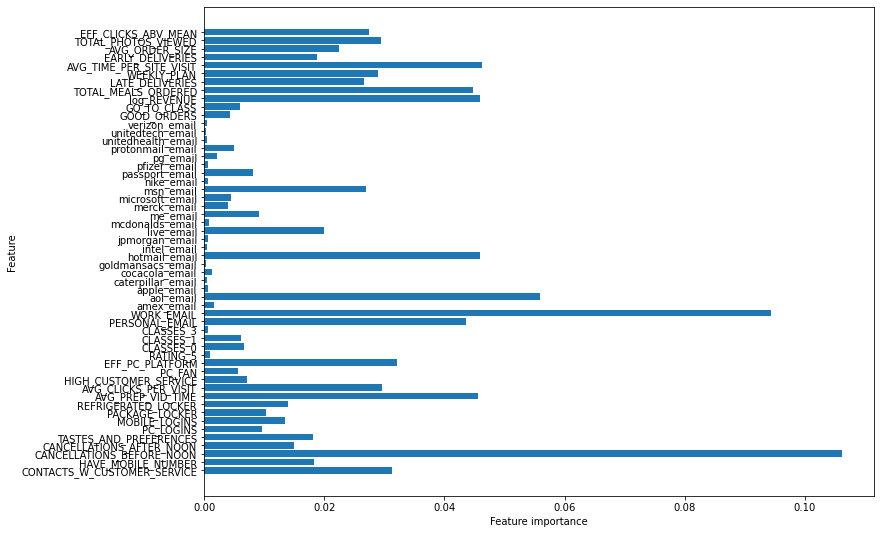

In [3]:
# Classification models
########################################################################################################################
########################################################################################################################
# massaging data for classification
########################################################################################################################
########################################################################################################################

#########################################################################################################################
#########################################################################################################################
# Data reading and massaging
#########################################################################################################################
#########################################################################################################################
# Correlations
## Importing packages
# importing essential libraries
import pandas as pd  # data science essentials
import matplotlib.pyplot as plt  # essential graphical output
import numpy as np  # essential math
import seaborn as sns  # enhanced graphical output
import statsmodels.formula.api as smf  # regression modeling

#import colors
import colorama
from colorama import Fore, Back, Style

# import packages for massaging
import gender_guesser.detector as gender  # to guess gender of names

# import packages for the models
from sklearn.model_selection import train_test_split  # train/test split
import sklearn.linear_model  # linear Models (scikit-learn) (OLS, Lasso, ARD)
from sklearn.metrics import confusion_matrix  # confusion matrix
from sklearn.metrics import roc_auc_score  # auc score
from sklearn.neighbors import KNeighborsClassifier  # KNN for classification
from sklearn.neighbors import KNeighborsRegressor  # KNN for regression
from sklearn.preprocessing import StandardScaler  # standard scaler
from sklearn.linear_model import LogisticRegression  # logistic regression

# libraries for classification trees
from sklearn.tree import DecisionTreeClassifier  # classification trees
from sklearn.tree import export_graphviz  # exports graphics
from six import StringIO  # saves objects in memory
from IPython.display import Image  # displays on frontend
import pydotplus  # interprets dot objects
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.metrics import make_scorer  # customizable scorer
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.ensemble import GradientBoostingClassifier  # gbm

## Reading datasets
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file names
dataset_file = './data/Apprentice_Chef_Dataset.xlsx'
dictionary_file = './data/Apprentice_Chef_Data_Dictionary.xlsx'

# reading the files into Python
chef = pd.read_excel(dataset_file)
dictionary = pd.read_excel(dictionary_file)

########################################################################################################################
################################################Massaging data##########################################################
########################################################################################################################
########################################################################################################################

## creating a copy of the original data set: "chef_new"

chef_new = chef.copy()

########################################################################################################################
########################################################################################################################

## Renaming variables
# LARGEST_ORDER_SIZE -> AVG_ORDER_SIZE

chef_new.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_ORDER_SIZE'}, inplace=True)

# MOBILE_NUMBER -> HAVE_MOBILE_NUMBER

chef_new.rename(columns={'MOBILE_NUMBER': 'HAVE_MOBILE_NUMBER'}, inplace=True)

########################################################################################################################
########################################################################################################################

## Classifying personal and work emails by domain

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_new.iterrows():

    # splitting email domain at '@'
    split_email = chef_new.loc[index, 'EMAIL'].split(sep="@")

    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)

# converting placeholder_lst into a DataFrame
email_df = pd.DataFrame(placeholder_lst)

# renaming column to concatenate
email_df.columns = ['0', 'email_domain']

# concatenating personal_email_domain with friends DataFrame
chef_new = pd.concat([chef_new, email_df['email_domain']], axis=1)

# email domain types
personal_email_domains = ['@gmail.com', '@yahoo.com', '@protonmail.com']

junk_email_domains = [
    '@msn.com', '@hotmail.com', '@live.com', '@me.com', '@aol.com',
    'passport.com'
]

work_email_domains = [
    '@mmm.com', '@amex.com', '@apple.com', '@boeing.com', '@caterpillar.com',
    '@chevron.com', '@cisco.com', '@cocacola.com', '@disney.com',
    '@dupont.com', '@exxon.com', '@ge.org', '@goldmansacs.com',
    '@homedepot.com', '@ibm.com', '@intel.com', '@jnj.com', '@jpmorgan.com',
    '@mcdonalds.com', '@merck.com', '@microsoft.com', '@nike.com',
    '@pfizer.com', '@pg.com', '@travelers.com', '@unitedtech.com',
    '@unitedhealth.com', '@verizon.com', '@visa.com', '@walmart.com'
]

# placeholder list
placeholder_lst = []

# looping to group observations by domain type
for domain in chef_new['email_domain']:
    if "@" + domain in personal_email_domains:
        placeholder_lst.append('personal')

    elif "@" + domain in junk_email_domains:
        placeholder_lst.append('junk')

    elif "@" + domain in work_email_domains:
        placeholder_lst.append('work')

    else:
        placeholder_lst.append('Nan')

# concatenating with original DataFrame
chef_new['domain_group'] = pd.Series(placeholder_lst)

########################################################################################################################
########################################################################################################################

## New columns to define new variables from other columns

# "EFF_CLICKS_ABV_MEAN" Show if clicks above average give more orders: if above average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] > chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = 0

# "EFF_CLICKS_BELOW_MEAN" Show if clicks above average give more orders: if below or equal average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] <= chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = 0

# "HIGH_CUSTOMER_SERVICE" Efficiency of customer service (if above median, bad):

# looping over CUSTOMER_SERVICE
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] >= chef_new[
            'CONTACTS_W_CUSTOMER_SERVICE'].median():
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 1
    else:
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 0

# "PC_FAN" Efficiency of PC_LOGINS (if above median, fan):

# looping over PC_LOGINS
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'PC_LOGINS'] >= chef_new['PC_LOGINS'].median():
        chef_new.loc[index, 'PC_FAN'] = 1
    else:
        chef_new.loc[index, 'PC_FAN'] = 0

########################################################################################################################
########################################################################################################################

## Creating new variables

# "EFF_PC_PLATFORM" Efficiency of categories : HAVE_MOBILE_NUMBER * PC_LOGINS
""" If user logs in having a phone number, it may mean that PC platform is easier than the app"""

chef_new[
    'EFF_PC_PLATFORM'] = chef_new['HAVE_MOBILE_NUMBER'] * chef_new['PC_LOGINS']

# "EFF_CATEGORIES" Efficiency of categories: TOTAL_MEALS_ORDERED / PRODUCT_CATEGORIES_VIEWED

chef_new['EFF_CATEGORIES'] = chef_new['TOTAL_MEALS_ORDERED'] / chef_new[
    'PRODUCT_CATEGORIES_VIEWED']

# Log Revenue

chef_new['log_REVENUE'] = np.log10(chef_new['REVENUE'])

# Total discounts for cancellations = cancelled before noon + (canceled after noon /2)

chef_new['total_discounts'] = chef_new['CANCELLATIONS_BEFORE_NOON'] + (
    chef_new['CANCELLATIONS_AFTER_NOON'] / 2)

########################################################################################################################
########################################################################################################################

## Get dummies variables for categorical variables

# one hot encoding categorical variables
one_hot_rating = pd.get_dummies(chef_new['MEDIAN_MEAL_RATING'])
one_hot_classes = pd.get_dummies(chef_new['MASTER_CLASSES_ATTENDED'])
one_hot_domain_group = pd.get_dummies(chef_new['domain_group'])

# labels

one_hot_rating.columns = [
    'RATING_1', 'RATING_2', 'RATING_3', 'RATING_4', 'RATING_5'
]
one_hot_classes.columns = ['CLASSES_0', 'CLASSES_1', 'CLASSES_2', 'CLASSES_3']
one_hot_domain_group.columns = [
    'NEW_EMAIL_DOMAIN', 'JUNK_EMAIL', 'PERSONAL_EMAIL', 'WORK_EMAIL'
]

# dropping categorical variables after they've been encoded
chef_new = chef_new.drop('MASTER_CLASSES_ATTENDED', axis=1)
chef_new = chef_new.drop('domain_group', axis=1)
chef_new = chef_new.drop('email_domain', axis=1)

# joining codings together
chef_new = chef_new.join(
    [one_hot_rating, one_hot_classes, one_hot_domain_group])
"""
    ,one_hot_email_domain
"""

# saving new columns
new_columns = chef_new.columns

########################################################################################################################
########################################################################################################################

# New variables from dummies

# "GOOD_ORDERS". Number of orders with 4 or 5 stars:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'RATING_4'] + chef_new.loc[index, 'RATING_5'] >= 1:
        chef_new.loc[index, 'GOOD_ORDERS'] = 1
    else:
        chef_new.loc[index, 'GOOD_ORDERS'] = 0

# "GO_TO_CLASS". Number of people that attend at least one class:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CLASSES_1'] + chef_new.loc[
            index, 'CLASSES_2'] + chef_new.loc[index, 'CLASSES_3'] >= 1:
        chef_new.loc[index, 'GO_TO_CLASS'] = 1
    else:
        chef_new.loc[index, 'GO_TO_CLASS'] = 0

# concatenating personal_email_domain with friends DataFrame
chef_new = pd.concat([chef_new, email_df['email_domain']], axis=1)

## Get dummies variables for categorical variables
one_hot_email_domain = pd.get_dummies(chef_new['email_domain'])

# labels
one_hot_email_domain.columns = [
    'amex_email', 'aol_email', 'apple_email', 'boeing_email',
    'caterpillar_email', 'chevron_email', 'cisco_email', 'cocacola_email',
    'disney_email', 'dupont_email', 'exxon_email', 'ge_email', 'gmail_email',
    'goldmansacs_email', 'homedepot_email', 'hotmail_email', 'ibm_email',
    'intel_email', 'jnj_email', 'jpmorgan_email', 'live_email',
    'mcdonalds_email', 'me_email', 'merck_email', 'microsoft_email',
    'mmm_email', 'msn_email', 'nike_email', 'passport_email', 'pfizer_email',
    'pg_email', 'protonmail_email', 'travelers_email', 'unitedhealth_email',
    'unitedtech_email', 'verizon_email', 'visa_email', 'walmart_email',
    'yahoo_email'
]

# dropping categorical variables after they've been encoded
chef_new = chef_new.drop('email_domain', axis=1)

# joining codings together
chef_new = chef_new.join([one_hot_email_domain])

# saving new columns
new_columns = chef_new.columns

# creating a (Pearson) correlation matrix
chef_corr = chef_new.corr().round(2)
"""
#printing (Pearson) correlations with SalePrice
print(chef_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending=False))
"""
chef_new = chef_new.drop(['NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME'],
                         axis=1)
########################################################################################################################
########################################################################################################################
#Initial approach 
########################################################################################################################
########################################################################################################################

# declaring explanatory variables
chef_data = chef_new.drop('CROSS_SELL_SUCCESS', axis=1)

# declaring response variable
chef_target = chef_new.loc[:, 'CROSS_SELL_SUCCESS']

# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(chef_data,
                                                    chef_target,
                                                    test_size=0.25,
                                                    random_state=219,
                                                    stratify=chef_target)

# merging training data for statsmodels
chef_train = pd.concat([x_train, y_train], axis=1)

#for val in chef_data:
#    print(f" {val} + ")
'''
# instantiating a logistic regression model object
logistic_small = smf.logit(
    formula=
    """CROSS_SELL_SUCCESS ~              AVG_TIME_PER_SITE_VISIT+ WEEKLY_PLAN+ LATE_DELIVERIES+
        TOTAL_MEALS_ORDERED+ AVG_PREP_VID_TIME+ log_REVENUE+ EARLY_DELIVERIES+CONTACTS_W_CUSTOMER_SERVICE+
    AVG_ORDER_SIZE+PRODUCT_CATEGORIES_VIEWED+EFF_CLICKS_ABV_MEAN+JUNK_EMAIL+EFF_PC_PLATFORM+CANCELLATIONS_BEFORE_NOON


""",
    data=chef_train)

# fitting the model object
results_logistic = logistic_small.fit()

# checking the results SUMMARY
print(results_logistic.summary())

#print(results_logistic.params)
print(results_logistic.pvalues[results_logistic.pvalues <= 0.1])
'''

########################################################################################################################
###################################USER DEFINED FUNCTIONS###############################################################
########################################################################################################################


# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize=True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""

    if standardize == True:
        # optionally standardizing X_data
        scaler = StandardScaler()
        scaler.fit(x_data)
        x_scaled = scaler.transform(x_data)
        x_scaled_df = pd.DataFrame(x_scaled)
        x_data = x_scaled_df

    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size=pct_test,
                                                        random_state=seed)

    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []

    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)

    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors=n_neighbors)
            clf.fit(x_train, y_train)

        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(x_train, y_train)

        else:
            print("Error: response_type must be 'reg' or 'class'")

        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))

        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))

    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12, 8))
        plt.plot(neighbors_settings,
                 training_accuracy,
                 label="training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()

    # returning optimal number of neighbors
    print(
        f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}"
    )
    return test_accuracy.index(max(test_accuracy)) + 1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels=None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true=true_y, y_pred=pred_y)

    # heatmap
    sns.heatmap(cm,
                annot=True,
                xticklabels=lbls,
                yticklabels=lbls,
                cmap='Blues',
                fmt='g')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()


########################################
# display_tree
########################################
def display_tree(tree, feature_df, height=500, width=800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    # exporting tree to graphviz
    export_graphviz(decision_tree=tree,
                    out_file=dot_data,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_df.columns)

    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # creating image
    img = Image(graph.create_png(), height=height, width=width)

    return img


########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export=False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """

    # declaring the number
    n_features = x_train.shape[1]

    # setting plot window
    fig, ax = plt.subplots(figsize=(12, 9))

    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')


########################################
# defining a function for boxplots
########################################


def model_boxplots(model, data):
    """
	This function is designed to generate a boxplot for predictions to compare.
    
    PARAMETERS
	----------
	model    : Model Predictions
	data     : DataFrame of the response and categorical variables
	"""

    fig, ax = plt.subplots(figsize=(10, 2))

    sns.boxplot(x=model, data=data)

    plt.suptitle(model)
    plt.show()
'''
# merging X_train and y_train so that they can be used in statsmodels
chef__reg_train = pd.concat([x_train_reg, y_train_reg], axis=1)

# Step 1: build a model
lm_best = smf.ols(formula="""REVENUE ~  TOTAL_MEALS_ORDERED +
                                        UNIQUE_MEALS_PURCH +
                                        AVG_TIME_PER_SITE_VISIT +
                                        PRODUCT_CATEGORIES_VIEWED+
                                        EFF_CATEGORIES+
                                        AVG_PREP_VID_TIME +
                                        AVG_ORDER_SIZE +
                                        MEDIAN_MEAL_RATING +
                                        TOTAL_PHOTOS_VIEWED +
                                        HIGH_CUSTOMER_SERVICE +
                                        RATING_4 +
                                        GO_TO_CLASS   """,
                  data=chef__reg_train)

# Step 2: fit the model based on the data
results = lm_best.fit()

# Step 3: analyze the summary output
print(results.summary())
'''
########################################################################################################################
########################################################################################################################

#dictionary of possible combinations
candidate_dict = {

    # 1 full model 0.6855

    #Tuned Parameters  : {'warm_start': False, 'n_estimators': 850, 'max_features': 'log2', 'max_depth': 1, 'learning_rate': 0.9}
    #Tuned Training AUC: 0.6387
    #Training ACCURACY: 0.7622
    #Testing  ACCURACY: 0.7659
    #AUC Score        : 0.6855

    #True Negatives : 72
    #False Positives: 84
    #False Negatives: 30
    #True Positives : 301
    'logit_full_1': [
        'CONTACTS_W_CUSTOMER_SERVICE', 'HAVE_MOBILE_NUMBER',
        'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
        'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS',
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
        'AVG_CLICKS_PER_VISIT', 'HIGH_CUSTOMER_SERVICE', 'PC_FAN',
        'EFF_PC_PLATFORM', 'RATING_5', 'CLASSES_0', 'CLASSES_1', 'CLASSES_3',
        'PERSONAL_EMAIL', 'WORK_EMAIL', 'amex_email', 'aol_email',
        'apple_email', 'caterpillar_email', 'cocacola_email',
        'goldmansacs_email', 'hotmail_email', 'intel_email', 'jpmorgan_email',
        'live_email', 'mcdonalds_email', 'me_email', 'merck_email',
        'microsoft_email', 'msn_email', 'nike_email', 'passport_email',
        'pfizer_email', 'pg_email', 'protonmail_email', 'unitedhealth_email',
        'unitedtech_email', 'verizon_email', 'GOOD_ORDERS', 'GO_TO_CLASS'
    ],

    # 2 full logit

    #                   Model Name  AUC Score  Training Accuracy  Testing Accuracy    Confusion Matrix
    #0                    Logistic     0.6166             0.7286            0.7207  (51, 105, 31, 300)
    #1                   Full Tree     0.5843             1.0000            0.6468   (64, 92, 80, 251)
    #2                 Pruned Tree     0.6223             0.7505            0.7146   (57, 99, 40, 291)
    #3                    LR Tuned     0.6389             0.7361            0.7372   (57, 99, 29, 302)
    #4                  Tuned Tree     0.6225             0.7368            0.7310  (50, 106, 25, 306)
    #5        Random Forest (Full)     0.6197             1.0000            0.7248  (51, 105, 29, 302)
    #6  Tuned Random Forest (Full)     0.6629             0.7642            0.7721  (56, 100, 11, 320)
    #7                  GBM (Full)     0.5827             0.9993            0.6838  (47, 286, 45, 286)
    #8                   Tuned GBM     1.0000             0.9993            1.0000    (156, 0, 0, 331)
    'logit_full': [
        'CONTACTS_W_CUSTOMER_SERVICE', 'HAVE_MOBILE_NUMBER',
        'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
        'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS',
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
        'AVG_CLICKS_PER_VISIT', 'HIGH_CUSTOMER_SERVICE', 'PC_FAN',
        'EFF_PC_PLATFORM', 'RATING_5', 'CLASSES_0', 'CLASSES_1', 'CLASSES_3',
        'PERSONAL_EMAIL', 'WORK_EMAIL', 'amex_email', 'aol_email',
        'apple_email', 'caterpillar_email', 'cocacola_email',
        'goldmansacs_email', 'hotmail_email', 'intel_email', 'jpmorgan_email',
        'live_email', 'mcdonalds_email', 'me_email', 'merck_email',
        'microsoft_email', 'msn_email', 'nike_email', 'passport_email',
        'pfizer_email', 'pg_email', 'protonmail_email', 'unitedhealth_email',
        'unitedtech_email', 'verizon_email', 'GOOD_ORDERS', 'GO_TO_CLASS',
        'log_REVENUE', 'TOTAL_MEALS_ORDERED', 'LATE_DELIVERIES', 'WEEKLY_PLAN',
        'AVG_TIME_PER_SITE_VISIT', 'EARLY_DELIVERIES', 'AVG_ORDER_SIZE',
        'TOTAL_PHOTOS_VIEWED', 'EFF_CLICKS_ABV_MEAN', 'JUNK_EMAIL',
        'WORK_EMAIL'
    ],

    # 3 full x variables
    #                   Model Name  AUC Score  Training Accuracy  Testing Accuracy    Confusion Matrix
    #0                    Logistic     0.5017             0.6813            0.6797    (1, 155, 1, 330)
    #1                   Full Tree     0.5663             1.0000            0.6201   (65, 91, 94, 237)
    #2                 Pruned Tree     0.6096             0.7512            0.7043  (54, 102, 42, 289)
    #3                    LR Tuned     0.6440             0.7313            0.7372   (60, 96, 32, 299)
    #4                  Tuned Tree     0.6327             0.7183            0.7310  (56, 100, 31, 300)
    #5        Random Forest (Full)     0.5901             1.0000            0.7146  (38, 118, 21, 310)
    #6  Tuned Random Forest (Full)     0.6863             0.7745            0.7947    (60, 96, 4, 327)
    #7                  GBM (Full)     0.6027             1.0000            0.7064  (49, 295, 36, 295)
    #8                   Tuned GBM     1.0000             1.0000            1.0000    (156, 0, 0, 331)
    'logit_full_2': [
        'WORK_EMAIL', 'CANCELLATIONS_BEFORE_NOON', 'total_discounts',
        'EFF_PC_PLATFORM', 'HAVE_MOBILE_NUMBER', 'TASTES_AND_PREFERENCES',
        'REFRIGERATED_LOCKER', 'merck_email', 'microsoft_email',
        'jpmorgan_email', 'amex_email', 'pg_email', 'GO_TO_CLASS', 'CLASSES_1',
        'intel_email', 'PACKAGE_LOCKER', 'HIGH_CUSTOMER_SERVICE',
        'caterpillar_email', 'CONTACTS_W_CUSTOMER_SERVICE', 'PC_LOGINS',
        'unitedhealth_email', 'PC_FAN', 'PERSONAL_EMAIL', 'unitedtech_email',
        'RATING_5', 'apple_email', 'cocacola_email', 'walmart_email',
        'protonmail_email', 'mcdonalds_email', 'verizon_email',
        'MEDIAN_MEAL_RATING', 'AVG_PREP_VID_TIME', 'goldmansacs_email',
        'pfizer_email', 'nike_email', 'RATING_4', 'GOOD_ORDERS',
        'boeing_email', 'EARLY_DELIVERIES', 'gmail_email', 'AVG_ORDER_SIZE',
        'ge_email', 'visa_email', 'travelers_email', 'cisco_email',
        'mmm_email', 'EFF_CLICKS_BELOW_MEAN', 'dupont_email', 'disney_email',
        'AVG_TIME_PER_SITE_VISIT', 'chevron_email', 'TOTAL_MEALS_ORDERED',
        'LATE_DELIVERIES', 'ibm_email', 'log_REVENUE', 'EFF_CATEGORIES',
        'TOTAL_PHOTOS_VIEWED', 'CLASSES_2', 'jnj_email', 'REVENUE', 'RATING_3',
        'PRODUCT_CATEGORIES_VIEWED', 'UNIQUE_MEALS_PURCH', 'yahoo_email',
        'exxon_email', 'RATING_2', 'WEEKLY_PLAN', 'homedepot_email',
        'RATING_1', 'EFF_CLICKS_ABV_MEAN', 'CLASSES_3', 'AVG_CLICKS_PER_VISIT',
        'MOBILE_LOGINS', 'CLASSES_0', 'CANCELLATIONS_AFTER_NOON', 'me_email',
        'NEW_EMAIL_DOMAIN', 'passport_email', 'live_email', 'msn_email',
        'hotmail_email', 'aol_email', 'JUNK_EMAIL'
    ],

    #significant variables as pruned tree
    'logit_sig_final': [
        'CONTACTS_W_CUSTOMER_SERVICE', 'HAVE_MOBILE_NUMBER',
        'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
        'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS',
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
        'AVG_CLICKS_PER_VISIT', 'HIGH_CUSTOMER_SERVICE', 'PC_FAN',
        'EFF_PC_PLATFORM', 'RATING_5', 'CLASSES_0', 'CLASSES_1', 'CLASSES_3',
        'PERSONAL_EMAIL', 'WORK_EMAIL', 'amex_email', 'aol_email',
        'apple_email', 'caterpillar_email', 'cocacola_email',
        'goldmansacs_email', 'hotmail_email', 'intel_email', 'jpmorgan_email',
        'live_email', 'mcdonalds_email', 'me_email', 'merck_email',
        'microsoft_email', 'msn_email', 'nike_email', 'passport_email',
        'pfizer_email', 'pg_email', 'protonmail_email', 'unitedhealth_email',
        'unitedtech_email', 'verizon_email', 'GOOD_ORDERS', 'GO_TO_CLASS','log_REVENUE',
        'TOTAL_MEALS_ORDERED','LATE_DELIVERIES','WEEKLY_PLAN','AVG_TIME_PER_SITE_VISIT','EARLY_DELIVERIES','AVG_ORDER_SIZE','TOTAL_PHOTOS_VIEWED', 
        'EFF_CLICKS_ABV_MEAN']
}

# train/test split with the full model
chef_data = chef_new.loc[:, candidate_dict['logit_sig_final']]
chef_target = chef_new.loc[:, 'CROSS_SELL_SUCCESS']

# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(chef_data,
                                                    chef_target,
                                                    random_state=219,
                                                    test_size=0.25,
                                                    stratify=chef_target)

# Tuned Random Forest
'''
# declaring a hyperparameter space
estimator_space  = np.arange(100, 1100, 250)
leaf_space       = np.arange(1, 31, 5)
criterion_space  = ['gini', 'entropy']
bootstrap_space  = [True, False]
warm_start_space = [True, False]
max_depth_space  = [4,8]

# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'min_samples_leaf' : leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space,
              'max_depth'        : max_depth_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 3,
                               n_iter     = 1000,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

# best estimators based on RandomizedSearchCV
print(forest_cv.best_estimator_)

Tuned Parameters  : {'warm_start': True, 'n_estimators': 350, 'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}
Tuned Training AUC: 0.5623
Best Estimator    : RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=350,
                       random_state=219, warm_start=True)
'''
# building a model based on hyperparameter tuning results

# to avoid running another RandomizedSearch
forest_tuned = RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=350,
                       random_state=219, warm_start=True)

# FITTING the model object
forest_tuned_fit = forest_tuned.fit(chef_data, chef_target)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

# plotting feature importances
plot_feature_importances(forest_tuned_fit,
                         train = x_train,
                         export = False)

# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()
'''
# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")
'''
# declaring model performance objects
tuned_rf_train_acc = forest_tuned_fit.score(x_train, y_train).round(4)
tuned_rf_test_acc  = forest_tuned_fit.score(x_test, y_test).round(4)
tuned_rf_auc       = roc_auc_score(y_true  = y_test,
                                   y_score = forest_tuned_pred).round(4)

## Conclusion

Focus on strategies to group users and the classes seem to be effective to reach our goals.